In [ ]:
!pip install mtcnn
!pip install face_recognition
!pip install pydub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from keras.optimizers import Adam

IMGWIDTH = 256

class Classifier:
    def __init__():
        self.model = 0

    def predict(self, x):
        return self.model.predict(x)

    def fit(self, x, y):
        return self.model.train_on_batch(x, y)

    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)

    def load(self, path):
        self.model.load_weights(path)


class Meso1(Classifier):
    def __init__(self, learning_rate = 0.001, dl_rate = 1):
        self.model = self.init_model(dl_rate)
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

    def init_model(self, dl_rate):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))

        x1 = Conv2D(16, (3, 3), dilation_rate = dl_rate, strides = 1, padding='same', activation = 'relu')(x)
        x1 = Conv2D(4, (1, 1), padding='same', activation = 'relu')(x1)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(8, 8), padding='same')(x1)

        y = Flatten()(x1)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)
        return KerasModel(inputs = x, outputs = y)


class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

    def init_model(self):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))

        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)


class MesoInception4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

    def InceptionLayer(self, a, b, c, d):
        def func(x):
            x1 = Conv2D(a, (1, 1), padding='same', activation='relu')(x)

            x2 = Conv2D(b, (1, 1), padding='same', activation='relu')(x)
            x2 = Conv2D(b, (3, 3), padding='same', activation='relu')(x2)

            x3 = Conv2D(c, (1, 1), padding='same', activation='relu')(x)
            x3 = Conv2D(c, (3, 3), dilation_rate = 2, strides = 1, padding='same', activation='relu')(x3)

            x4 = Conv2D(d, (1, 1), padding='same', activation='relu')(x)
            x4 = Conv2D(d, (3, 3), dilation_rate = 3, strides = 1, padding='same', activation='relu')(x4)

            y = Concatenate(axis = -1)([x1, x2, x3, x4])

            return y
        return func

    def init_model(self):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))

        x1 = self.InceptionLayer(1, 4, 4, 2)(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = self.InceptionLayer(2, 4, 4, 2)(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)

In [ ]:
import random
from os import listdir
from os.path import isfile, join

import numpy as np
from math import floor
from scipy.ndimage.interpolation import zoom, rotate

import imageio
import face_recognition


class Video:
    def __init__(self, path):
        self.path = path
        self.container = imageio.get_reader(path, 'ffmpeg')
        self.length = self.container.count_frames()
        self.fps = self.container.get_meta_data()['fps']

    def init_head(self):
        self.container.set_image_index(0)

    def next_frame(self):
        self.container.get_next_data()

    def get(self, key):
        return self.container.get_data(key)

    def __call__(self, key):
        return self.get(key)

    def __len__(self):
        return self.length


class FaceFinder(Video):
    def __init__(self, path, load_first_face = True):
        super().__init__(path)
        self.faces = {}
        self.coordinates = {}
        self.last_frame = self.get(0)
        self.frame_shape = self.last_frame.shape[:2]
        self.last_location = (0, 200, 200, 0)
        if (load_first_face):
            face_positions = face_recognition.face_locations(self.last_frame, number_of_times_to_upsample=2)
            if len(face_positions) > 0:
                self.last_location = face_positions[0]

    def load_coordinates(self, filename):
        np_coords = np.load(filename)
        self.coordinates = np_coords.item()

    def expand_location_zone(self, loc, margin = 0.2):
        offset = round(margin * (loc[2] - loc[0]))
        y0 = max(loc[0] - offset, 0)
        x1 = min(loc[1] + offset, self.frame_shape[1])
        y1 = min(loc[2] + offset, self.frame_shape[0])
        x0 = max(loc[3] - offset, 0)
        return (y0, x1, y1, x0)

    @staticmethod
    def upsample_location(reduced_location, upsampled_origin, factor):
        y0, x1, y1, x0 = reduced_location
        Y0 = round(upsampled_origin[0] + y0 * factor)
        X1 = round(upsampled_origin[1] + x1 * factor)
        Y1 = round(upsampled_origin[0] + y1 * factor)
        X0 = round(upsampled_origin[1] + x0 * factor)
        return (Y0, X1, Y1, X0)

    @staticmethod
    def pop_largest_location(location_list):
        max_location = location_list[0]
        max_size = 0
        if len(location_list) > 1:
            for location in location_list:
                size = location[2] - location[0]
                if size > max_size:
                    max_size = size
                    max_location = location
        return max_location

    @staticmethod
    def L2(A, B):
        return np.sqrt(np.sum(np.square(A - B)))

    def find_coordinates(self, landmark, K = 2.2):
        E1 = np.mean(landmark['left_eye'], axis=0)
        E2 = np.mean(landmark['right_eye'], axis=0)
        E = (E1 + E2) / 2
        N = np.mean(landmark['nose_tip'], axis=0) / 2 + np.mean(landmark['nose_bridge'], axis=0) / 2
        B1 = np.mean(landmark['top_lip'], axis=0)
        B2 = np.mean(landmark['bottom_lip'], axis=0)
        B = (B1 + B2) / 2

        C = N
        l1 = self.L2(E1, E2)
        l2 = self.L2(B, E)
        l = max(l1, l2) * K
        if (B[1] == E[1]):
            if (B[0] > E[0]):
                rot = 90
            else:
                rot = -90
        else:
            rot = np.arctan((B[0] - E[0]) / (B[1] - E[1])) / np.pi * 180

        return ((floor(C[1]), floor(C[0])), floor(l), rot)


    def find_faces(self, resize = 0.5, stop = 0, skipstep = 0, no_face_acceleration_threshold = 3, cut_left = 0, cut_right = -1, use_frameset = False, frameset = []):
        not_found = 0
        no_face = 0
        no_face_acc = 0

        if (use_frameset):
            finder_frameset = frameset
        else:
            if (stop != 0):
                finder_frameset = range(0, min(self.length, stop), skipstep + 1)
            else:
                finder_frameset = range(0, self.length, skipstep + 1)

        for i in finder_frameset:
            frame = self.get(i)
            if (cut_left != 0 or cut_right != -1):
                frame[:, :cut_left] = 0
                frame[:, cut_right:] = 0

            potential_location = self.expand_location_zone(self.last_location)
            potential_face_patch = frame[potential_location[0]:potential_location[2], potential_location[3]:potential_location[1]]
            potential_face_patch_origin = (potential_location[0], potential_location[3])

            reduced_potential_face_patch = zoom(potential_face_patch, (resize, resize, 1))
            reduced_face_locations = face_recognition.face_locations(reduced_potential_face_patch, model = 'cnn')

            if len(reduced_face_locations) > 0:
                no_face_acc = 0

                reduced_face_location = self.pop_largest_location(reduced_face_locations)
                face_location = self.upsample_location(reduced_face_location,
                                                    potential_face_patch_origin,
                                                    1 / resize)
                self.faces[i] = face_location
                self.last_location = face_location
                landmarks = face_recognition.face_landmarks(frame, [face_location])
                if len(landmarks) > 0:
                    self.coordinates[i] = self.find_coordinates(landmarks[0])
            else:
                not_found += 1

                if no_face_acc < no_face_acceleration_threshold:
                    face_locations = face_recognition.face_locations(frame, number_of_times_to_upsample = 2)
                else:
                    reduced_frame = zoom(frame, (resize, resize, 1))
                    face_locations = face_recognition.face_locations(reduced_frame)

                if len(face_locations) > 0:
                    print('Face extraction warning : ', i, '- found face in full frame', face_locations)
                    no_face_acc = 0

                    face_location = self.pop_largest_location(face_locations)

                    if no_face_acc > no_face_acceleration_threshold:
                        face_location = self.upsample_location(face_location, (0, 0), 1 / resize)

                    self.faces[i] = face_location
                    self.last_location = face_location


                    landmarks = face_recognition.face_landmarks(frame, [face_location])
                    if len(landmarks) > 0:
                        self.coordinates[i] = self.find_coordinates(landmarks[0])
                else:
                    print('Face extraction warning : ',i, '- no face')
                    no_face_acc += 1
                    no_face += 1

        print('Face extraction report of', 'not_found :', not_found)
        print('Face extraction report of', 'no_face :', no_face)
        return 0

    def get_face(self, i):

        frame = self.get(i)
        if i in self.faces:
            loc = self.faces[i]
            patch = frame[loc[0]:loc[2], loc[3]:loc[1]]
            return patch
        return frame

    @staticmethod
    def get_image_slice(img, y0, y1, x0, x1):
        m, n = img.shape[:2]
        padding = max(-y0, y1-m, -x0, x1-n, 0)
        padded_img = np.pad(img, ((padding, padding), (padding, padding), (0, 0)), 'reflect')
        return padded_img[(padding + y0):(padding + y1),
                        (padding + x0):(padding + x1)]

    def get_aligned_face(self, i, l_factor = 1.3):

        frame = self.get(i)
        if i in self.coordinates:
            c, l, r = self.coordinates[i]
            l = int(l) * l_factor
            dl_ = floor(np.sqrt(2) * l / 2)
            patch = self.get_image_slice(frame,
                                    floor(c[0] - dl_),
                                    floor(c[0] + dl_),
                                    floor(c[1] - dl_),
                                    floor(c[1] + dl_))
            rotated_patch = rotate(patch, -r, reshape=False)
            return self.get_image_slice(rotated_patch,
                                    floor(dl_-l//2),
                                    floor(dl_+l//2),
                                    floor(dl_-l//2),
                                    floor(dl_+l//2))
        return frame

class FaceBatchGenerator:

    def __init__(self, face_finder, target_size = 256):
        self.finder = face_finder
        self.target_size = target_size
        self.head = 0
        self.length = int(face_finder.length)

    def resize_patch(self, patch):
        m, n = patch.shape[:2]
        return zoom(patch, (self.target_size / m, self.target_size / n, 1))

    def next_batch(self, batch_size = 50):
        batch = np.zeros((1, self.target_size, self.target_size, 3))
        stop = min(self.head + batch_size, self.length)
        i = 0
        while (i < batch_size) and (self.head < self.length):
            if self.head in self.finder.coordinates:
                patch = self.finder.get_aligned_face(self.head)
                batch = np.concatenate((batch, np.expand_dims(self.resize_patch(patch), axis = 0)),
                                        axis = 0)
                i += 1
            self.head += 1
        return batch[1:]


def predict_faces(generator, classifier, batch_size = 50, output_size = 1):

    n = len(generator.finder.coordinates.items())
    profile = np.zeros((1, output_size))
    for epoch in range(n // batch_size + 1):
        face_batch = generator.next_batch(batch_size = batch_size)
        prediction = classifier.predict(face_batch)
        if (len(prediction) > 0):
            profile = np.concatenate((profile, prediction))
    return profile[1:]


def compute_accuracy(classifier, dirname, frame_subsample_count = 30):

    filenames = [f for f in listdir(dirname) if isfile(join(dirname, f)) and ((f[-4:] == '.mp4') or (f[-4:] == '.avi') or (f[-4:] == '.mov'))]
    predictions = {}

    for vid in filenames:
        print('Dealing with video ', vid)
        face_finder = FaceFinder(join(dirname, vid), load_first_face = False)
        skipstep = max(floor(face_finder.length / frame_subsample_count), 0)
        face_finder.find_faces(resize=0.5, skipstep = skipstep)

        print('Predicting ', vid)
        gen = FaceBatchGenerator(face_finder)
        p = predict_faces(gen, classifier)

        predictions[vid[:-4]] = (np.mean(p > 0.5), p)
    return predictions

<ipython-input-4-6f7fe701048f>:10: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom, rotate
<ipython-input-4-6f7fe701048f>:10: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom, rotate


In [ ]:
%cd /content/drive/MyDrive/Meso
! python extractFaceFromVideo.py

[Errno 2] No such file or directory: '/content/drive/MyDrive/DeepFake-Detection-master'
/content/drive/MyDrive/DeepFake-Detection-master
['/content/drive/My Drive/Meso/Test/test_videos/aassnaulhq.mp4', '/content/drive/My Drive/Meso/Test/test_videos/friends.mp4', '/content/drive/My Drive/Meso/Test/test_videos/tbbt.mp4']
2023-12-26 15:21:47.992438: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 15:21:47.992491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 15:21:47.993878: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 15:21:49.604304: W tensorflow/com

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import cv2
plt.style.use('ggplot')
train_dir = '/content/drive/My Drive/Meso/Test/test_videos/'
train_video_files = [train_dir + i for i in os.listdir(train_dir)]
print(train_video_files)

['/content/drive/My Drive/Meso/Test/test_videos/aassnaulhq.mp4', '/content/drive/My Drive/Meso/Test/test_videos/friends.mp4', '/content/drive/My Drive/Meso/Test/test_videos/tbbt.mp4']


1/1 [==============================] - 0s 252ms/step
[{'box': [433, 82, 98, 139], 'confidence': 0.9999860525131226, 'keypoints': {'left_eye': (495, 144), 'right_eye': (526, 141), 'nose': (525, 171), 'mouth_left': (493, 194), 'mouth_right': (517, 193)}}, {'box': [772, 199, 94, 149], 'confidence': 0.9987252354621887, 'keypoints': {'left_eye': (782, 259), 'right_eye': (806, 256), 'nose': (776, 283), 'mouth_left': (782, 313), 'mouth_right': (800, 312)}}]
2


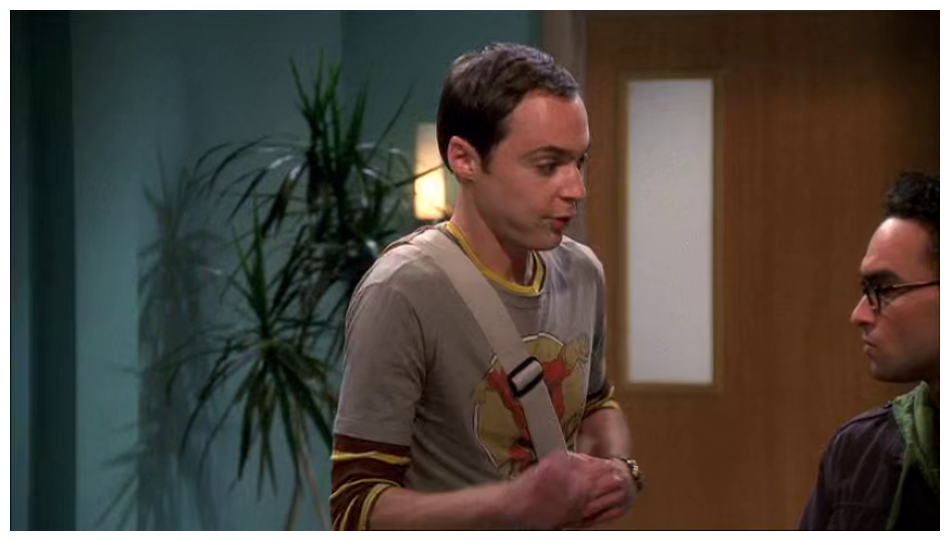

In [ ]:
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
v_cap = cv2.VideoCapture(train_video_files[2])
_, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(frame, cmap = 'gray')
plt.axis('off')

result = detector.detect_faces(frame)
print(result)
print(len(result))

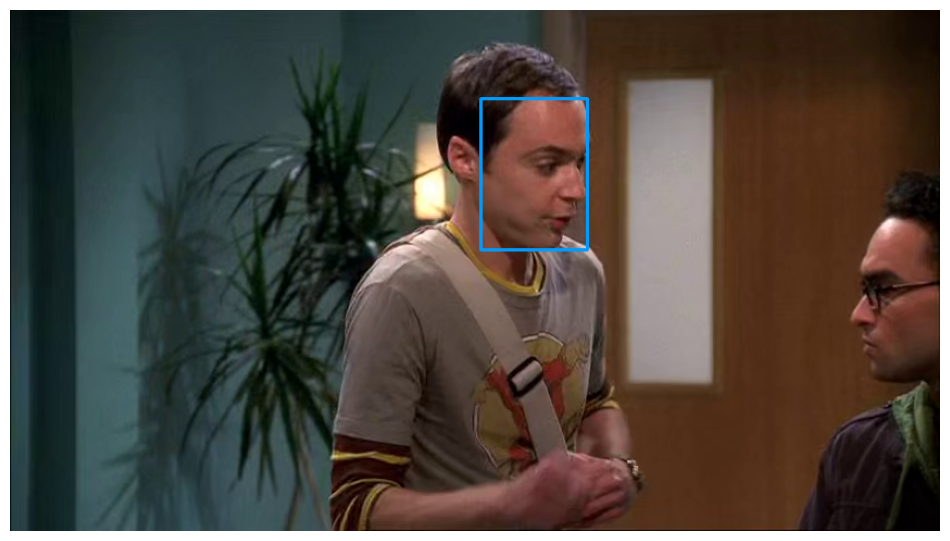

(139, 98, 3)
(128, 128, 3)


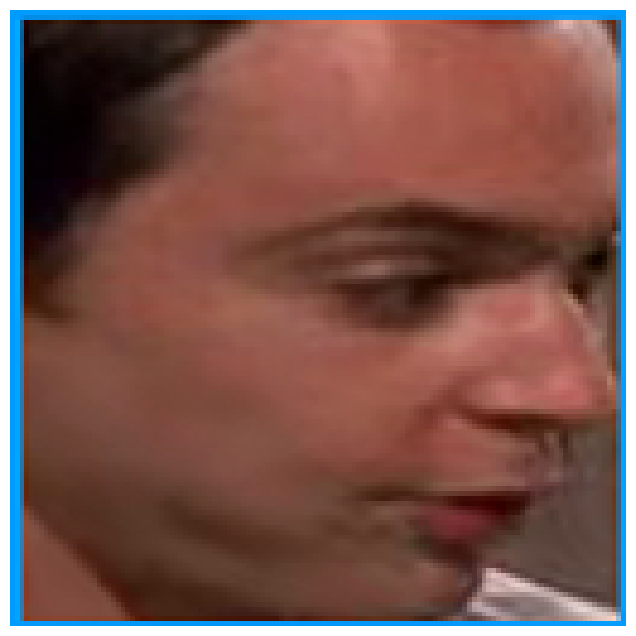

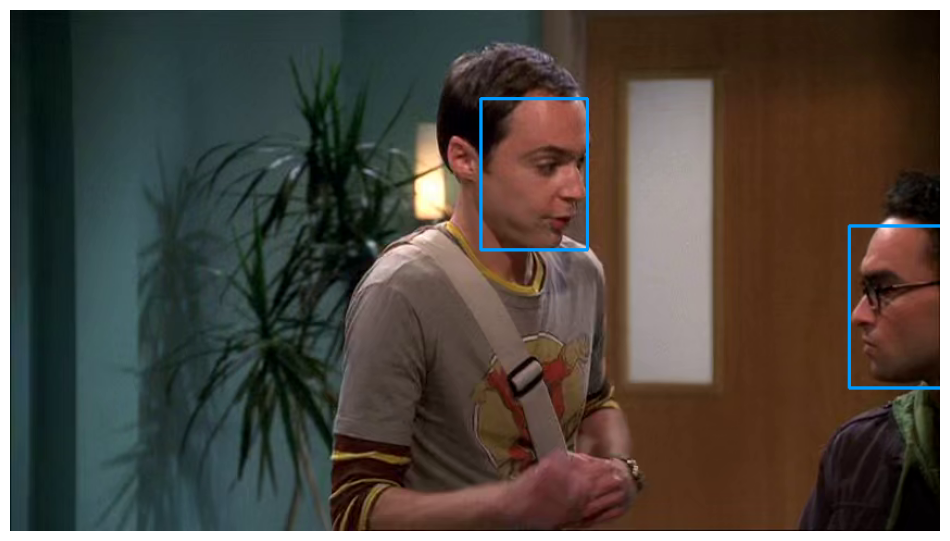

(149, 84, 3)
(128, 128, 3)


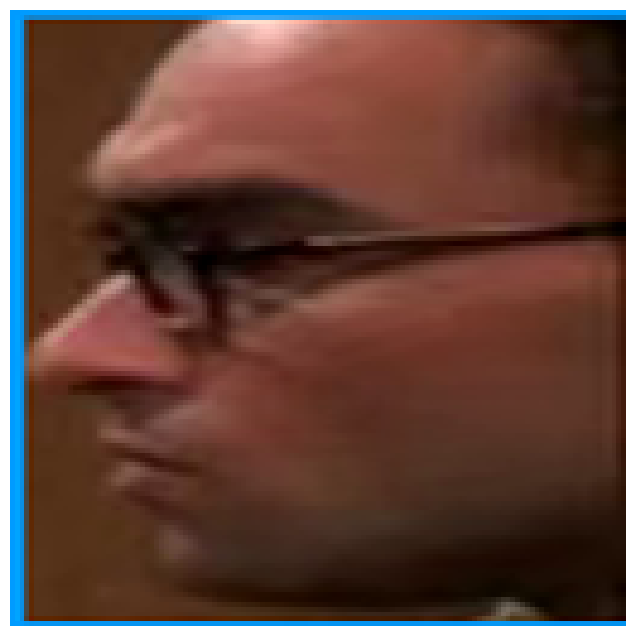

In [ ]:
def img_enhancement(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    hist_equalized_image = clahe.apply(image)
    return(hist_equalized_image)

import os
from PIL import Image
for j in range(len(result)):
    bounding_box = result[j]['box']
    cv2.rectangle(frame,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              2)
    plt.figure(figsize=(12, 8))
    plt.imshow(frame)
    plt.axis("off")
    plt.show()
    frame_cropped = frame[bounding_box[1] : bounding_box[1] + bounding_box[3], bounding_box[0] : bounding_box[0] + bounding_box[2]]
    plt.figure(figsize=(12, 8))
    im = frame_cropped
    print(im.shape)
    previous_size_im = im
    new_size_im = cv2.resize(previous_size_im,(128,128),interpolation=cv2.INTER_CUBIC )
    plt.imshow(new_size_im)

    directory = '/content/drive/My Drive/Meso/Test/test_images/test_folder/'
    os.chdir(directory)

    saved_image = Image.fromarray(new_size_im)
    saved_image.save("your_file" + str(j) + ".jpeg")
    print(new_size_im.shape)
    plt.axis("off")
    plt.show()

In [ ]:
from pydub import AudioSegment

audio = AudioSegment.from_file("/content/audio/sample.wav", format="wav")
segment_length = 5000
segments = [audio[i:i+segment_length] for i in range(0, len(audio), segment_length)]
normalized_segments = [segment.normalize() for segment in segments]
model = MesoInception4()
features = []
for segment in normalized_segments:
    waveform = segment.get_array_of_samples()
    feature = model.extract_features(waveform)
    features.append(feature)